In [1]:
from mountain import Mountain_one
import matplotlib.pyplot as plt
import numpy as np

In [2]:
np.random.seed(0)

In [3]:
def policy_evaluation(env, policy, gamma=0.99, eps=1e-4, order='rtl', k=None):
    """
    Evaluate a policy given an environment and a description of it.
    
    Parameters:
        env: Environment which is an instance of the Mountain class.
        policy: A function that maps a state to an action.
        gamma: Discount factor.
        eps: Threshold for stopping the evaluation.
        order: Order in which to update the states.
        k: Number of sweeps for policy evaluation. If None, evaluation continues until convergence.
    
    Returns:
        State-value function.
    """
    V = np.zeros((31, 100))
    iteration_count = 0
    while k is None or k > 0:
        delta = 0
        states = [(i, j) for i in range(31) for j in range(100)]
        if order == 'rtl':
            states.reverse()

        for state in states:
            v = 0
            action_probabilities = policy(state)

            # Bellman Expectation Equation
            for action, prob in action_probabilities.items():
                next_state = env.next_state(state, action)
                reward = env.get_reward(state, action)
                v += prob * (reward + gamma * V[next_state])

            delta = max(delta, np.abs(v - V[state]))
            V[state[0], state[1]] = v

        iteration_count += 1

        if delta < eps:
            break

        if k is not None:
            k -= 1

    print("[Policy Evaluation] Number of iterations:", iteration_count)

    return V

2. Consider the policy $\pi_{str}$ of heading straight ahead. Use policy evaluation to compute $v_{\pi_{str}}$.

In [4]:
def policy_straight(state):
    return {"forward": 1}

3. (*) Run your policy evaluation ordering the states from left to right (from the top of the mountain to the bottom) 
or from right to left (from the bottom of the mountain to the top). How do the results differ?

In [5]:
env = Mountain_one()
v_straight_left_to_right = policy_evaluation(env, policy_straight, order='ltr')

[Policy Evaluation] Number of iterations: 99


In [6]:
v_straight_right_to_left = policy_evaluation(env, policy_straight, order='rtl')

[Policy Evaluation] Number of iterations: 2


4. Plot the trajectory followed by the robot according to $\pi_{str}$ from $s_0$ = (15, 0).
5. Plot the trajectory followed by the robot according to $\pi_{str}$ from $s_0$ = (3, 0).

In [7]:
def plot_trajectory(env, policy, initial_state):
    mountain_map = env.get_map()

    fig, ax = plt.subplots()
    ax.imshow(mountain_map, cmap='Greys_r')
    ax.set_title('Mountain Terrain')
    ax.set_xticks(np.arange(0, 101, 20))
    ax.set_yticks(np.arange(0, 32, 10))
    ax.grid(True)

    current_state = initial_state
    trajectory = [current_state]

    while current_state[1] < 99:
        action_probabilities = policy(current_state)
        actions, probabilities = zip(*action_probabilities.items())
        action = np.random.choice(actions, p=probabilities)  # choose action based on probabilities
        next_state = env.next_state(current_state, action)
        trajectory.append(next_state)
        current_state = next_state

    x, y = zip(*[(state[1], state[0]) for state in trajectory])

    ax.plot(x, y, marker='.', linestyle='-', color='slateblue')
    plt.show()

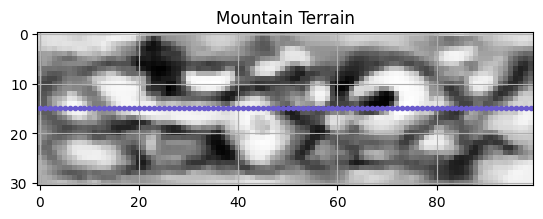

In [8]:
plot_trajectory(env, policy_straight, (15, 0))

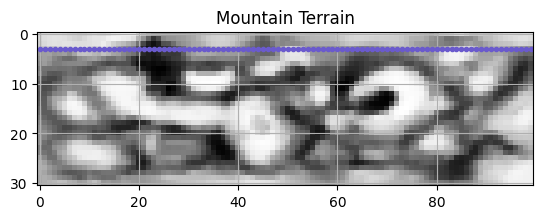

In [9]:
plot_trajectory(env, policy_straight, (3, 0))

6. If the agent were to follow the policy $\pi_{str}$, which starting position in the first column would be optimal?

In [10]:
optimal_starting_pos = v_straight_left_to_right[:, 0].argmax()
print("Optimal starting position in the first column:", optimal_starting_pos)

Optimal starting position in the first column: 7


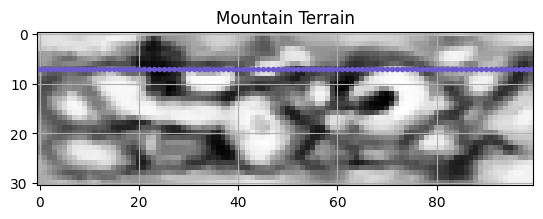

In [11]:
plot_trajectory(env, policy_straight, (optimal_starting_pos, 0))

8. Consider now a random policy $\pi_{rnd}$ where each action is taken with uniform probability. Use policy evaluation to compute $v_{\pi_{str}}$.

In [12]:
def policy_random(state):
    actions = ["upforward", "forward", "downforward"]
    action_probabilities = {action: 1 / 3 for action in actions}
    return action_probabilities

In [13]:
v_random_left_to_right = policy_evaluation(env, policy_random, order='ltr')

[Policy Evaluation] Number of iterations: 85


In [14]:
v_random_right_to_left = policy_evaluation(env, policy_random, order='rtl')

[Policy Evaluation] Number of iterations: 51


In [15]:
# v_random_left_to_right == v_random_right_to_left

9. Plot one sample trajectory that the robot could follow according to $\pi_{rnd}$ from $s_0$ = (15, 0).

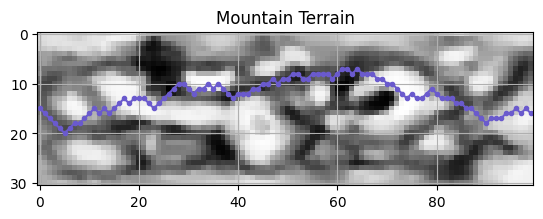

In [16]:
plot_trajectory(env, policy_random, (15, 0))

11. (*) Compare $v_{\pi_{str}}$((15,0)), $v_{\pi_{str}}$((3,0)), $v_{\pi_{rnd}}$((15,0)). If the robot can choose its initial position and its policy, which of the previous 
combination of initial state and policy has the highest value?

In [17]:
v_pi_str_15_0 = policy_evaluation(env, policy_straight)[15, 0]
v_pi_str_3_0 = policy_evaluation(env, policy_straight)[3, 0]
v_pi_rnd_15_0 = policy_evaluation(env, policy_random)[15, 0]

print("State value for initial state (15, 0) under policy π_str:", v_pi_str_15_0)
print("State value for initial state (3, 0) under policy π_str:", v_pi_str_3_0)
print("State value for initial state (15, 0) under policy π_rnd:", v_pi_rnd_15_0)

[Policy Evaluation] Number of iterations: 2
[Policy Evaluation] Number of iterations: 2
[Policy Evaluation] Number of iterations: 51
State value for initial state (15, 0) under policy π_str: -38.58721894017477
State value for initial state (3, 0) under policy π_str: -33.8577150511237
State value for initial state (15, 0) under policy π_rnd: -33.246147020948456


In [18]:
best_combination = max([("π_str", "(15, 0)", v_pi_str_15_0),
                        ("π_str", "(3, 0)", v_pi_str_3_0),
                        ("π_rnd", "(15, 0)", v_pi_rnd_15_0)], key=lambda x: x[2])

print("The best combination is:", best_combination)

The best combination is: ('π_rnd', '(15, 0)', -33.246147020948456)


12. Reconsider the three policy evaluation that you have run. Is the issue of exploration affecting the final result?

Exploration affects the policy evaluations for $\pi_{str}$ and $\pi_{rnd}$ differently. The deterministic $\pi_{str}$ doesn't explore and thus only evaluates the value of moving straight, potentially missing out on better paths. In contrast, the random $\pi_{rnd}$ explores various routes due to its stochastic nature, considering a wider range of states which may lead to discovering more efficient paths down the mountain. Therefore, $\pi_{rnd}$'s evaluation likely gives a more accurate reflection of the expected returns, given the robot's desire to find the fastest and least uneven path.

Instead of just evaluating possible policies, the robot now considers trying to learn an optimal policy. Implement an algorithm for policy iteration.

13. Start from $\pi_{rnd}$; find an optimal policy using standard policy iteration where you alternate: 
    (i) policy evaluation until the state values are stable (they change less than a ε threshold); and, 
    (ii) policy improvement.

In [19]:
def policy_improvement(env, V, gamma=0.99):
    """
    Performs one incremental step in improving a given policy.
    
    Parameters:
        env: Environment which is an instance of the Mountain class.
        V: Current value function.
        gamma: Discount factor.
    
    Returns:
        Improved policy, where keys are states and values are the actions that should be taken in each state.
    """
    improved_policy = {}
    for state in [(i, j) for i in range(31) for j in range(100)]:
        action_values = {action: env.get_reward(state, action) + gamma * V[env.next_state(state, action)]
                         for action in env.actions}
        improved_policy[state] = max(action_values, key=action_values.get)
    return improved_policy

In [20]:
def standard_policy_iteration(env, gamma=0.99, eps=1e-4):
    """
    Perform standard policy iteration on an environment.

    Parameters:
        env: Environment which is an instance of the Mountain class.
        gamma: Discount factor.
        eps: Threshold for stopping the policy evaluation step.

    Returns:
        Optimal policy.
    """

    policy = {state: np.random.choice(env.actions) for i in range(31) for j in range(100) for state in [(i, j)]}

    iteration_count = 0

    while True:
        V = policy_evaluation(env, policy_random, gamma, eps)
        new_policy = policy_improvement(env, V, gamma)
        iteration_count += 1
        if new_policy == policy:
            break
        policy = new_policy

    print("[Standard Policy Iteration] Number of iterations:", iteration_count)

    optimal_policy = {state: {action: 1 if action == policy[state] else 0 for action in env.actions}
                      for state in policy}
    return optimal_policy

In [21]:
optimal_standard_policy = standard_policy_iteration(env)

[Policy Evaluation] Number of iterations: 51
[Policy Evaluation] Number of iterations: 51
[Standard Policy Iteration] Number of iterations: 2


14. Plot the optimal trajectory.

In [22]:
def plot_optimal_trajectory(env, policy, initial_state, policy_iteration_name):
    mountain_map = env.get_map()
    fig, ax = plt.subplots()
    ax.imshow(mountain_map, cmap='Greys_r')
    ax.set_title(f'[{policy_iteration_name}]\nOptimal Trajectory on Mountain Terrain')
    ax.set_xticks(np.arange(0, 101, 20))
    ax.set_yticks(np.arange(0, 32, 10))
    ax.grid(True)

    current_state = initial_state
    trajectory = [current_state]

    while current_state[1] < 99:
        action_probabilities = policy[current_state]
        action = max(action_probabilities, key=action_probabilities.get)  # action with the highest probability
        next_state = env.next_state(current_state, action)
        trajectory.append(next_state)
        current_state = next_state

    x, y = zip(*[(state[1], state[0]) for state in trajectory])
    ax.plot(x, y, marker='.', linestyle='-', color='slateblue')
    plt.show()

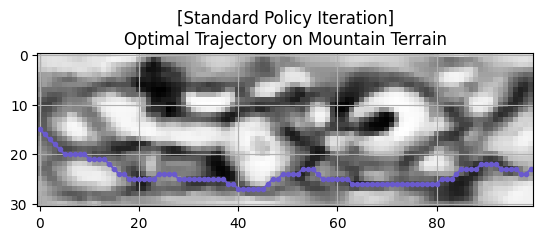

In [23]:
plot_optimal_trajectory(env, optimal_standard_policy, (15,0), "Standard Policy Iteration")

15. Always start from $\pi_{rnd}$; find an optimal policy using truncated policy iteration where you alternate: 
    (i) $k$ = 3 steps of policy evaluation; and, 
    (ii) policy improvement.

In [24]:
def truncated_policy_iteration(env, gamma=0.99, eps=1e-4, k=3):
    """
    Perform truncated policy iteration on an environment.

    Parameters:
        env: Environment which is an instance of the Mountain class.
        gamma: Discount factor.
        eps: Threshold for stopping the policy evaluation step.
        k: Number of sweeps of policy evaluation to perform before policy improvement.

    Returns:
        Optimal policy.
    """
    policy = {state: np.random.choice(env.actions) for i in range(31) for j in range(100) for state in [(i, j)]}

    iteration_count = 0

    while True:
        V = policy_evaluation(env, policy_random, gamma, eps, k=k)
        new_policy = policy_improvement(env, V, gamma)
        iteration_count += 1
        if new_policy == policy:
            break
        policy = new_policy

    print("[Truncated Policy Iteration] Number of iterations:", iteration_count)

    optimal_policy = {state: {action: 1 if action == policy[state] else 0 for action in env.actions} for state in
                      policy}
    return optimal_policy

In [25]:
optimal_truncated3_policy = truncated_policy_iteration(env, k=3)

[Policy Evaluation] Number of iterations: 3
[Policy Evaluation] Number of iterations: 3
[Truncated Policy Iteration] Number of iterations: 2



16. Plot the optimal trajectory.

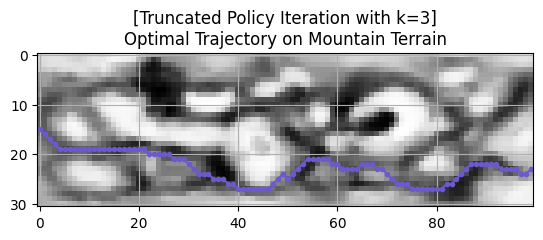

In [26]:
plot_optimal_trajectory(env, optimal_truncated3_policy, (15, 0), "Truncated Policy Iteration with k=3")

17. Start at $s_0$ = (15,0) and $\pi_{rnd}$; find an optimal policy using value iteration. Implement value iteration both as a form of $k$ = 1 
truncated policy iteration and as a direct implementation of the Bellman optimality equation.

In [27]:
def value_iteration(env, gamma=0.99, eps=1e-4):
    """
    Perform value iteration on an environment.

    Parameters:
        env: Environment which is an instance of the Mountain class.
        gamma: Discount factor.
        eps: Threshold for stopping criterion based on the maximum change in the value function between iterations.

    Returns:
        Optimal policy.
    """
    V = np.zeros((31, 100))

    iteration_count = 0

    while True:
        delta = 0
        for state in [(i, j) for i in range(31) for j in range(100)]:
            v = V[state]

            # Bellman Optimality Equation as update rule
            V[state] = max(env.get_reward(state, action) + gamma * V[env.next_state(state, action)]
                           for action in env.actions)

            delta = max(delta, abs(v - V[state]))
        iteration_count += 1
        if delta < eps:
            break
    
    # derive the optimal policy from the value function
    optimal_policy = {}
    for state in [(i, j) for i in range(31) for j in range(100)]:
        action_values = {action: env.get_reward(state, action) + gamma * V[env.next_state(state, action)]
                         for action in env.actions}
        best_action = max(action_values, key=action_values.get)
        # assign 1 to the best action, 0 to others
        optimal_policy[state] = {action: (1 if action == best_action else 0) for action in env.actions}

    print("[Value Iteration] Number of iterations:", iteration_count)
    return optimal_policy

In [28]:
optimal_truncated1_policy = truncated_policy_iteration(env, k=1)

[Policy Evaluation] Number of iterations: 1
[Policy Evaluation] Number of iterations: 1
[Truncated Policy Iteration] Number of iterations: 2


In [29]:
optimal_value_iteration_policy = value_iteration(env)

[Value Iteration] Number of iterations: 90


18. Plot the optimal trajectory.

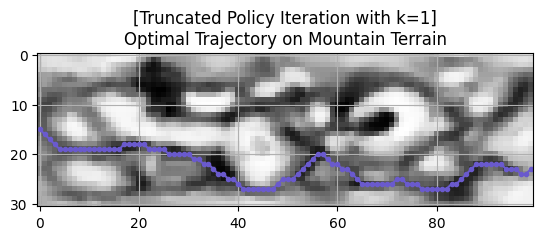

In [30]:
plot_optimal_trajectory(env, optimal_truncated1_policy, (15, 0), "Truncated Policy Iteration with k=1")

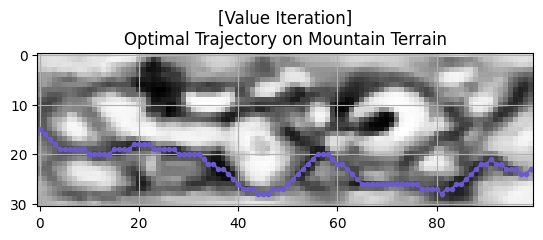

In [31]:
plot_optimal_trajectory(env, optimal_value_iteration_policy, (15, 0), "Value Iteration")